In [13]:
### imports

### DEV
from samcc_turbo import wrappers, socket_parser, socketClass, helper_functions, bundleClass
import importlib
importlib.reload(wrappers)
importlib.reload(socket_parser)
importlib.reload(socketClass)
importlib.reload(bundleClass)
importlib.reload(helper_functions)

### END-DEV

import pickle
import sys
from samcc_turbo.wrappers import run_dssp
from samcc_turbo.wrappers import run_socket
from samcc_turbo.socket_parser import parse_socket_output
from samcc_turbo.socketClass import socket_class
from samcc_turbo.bundleClass import bundleClass

bin_paths = {'dssp':'dssp', 'socket':'/home/kszczepaniak/Apps/socket3.03/socket'}

In [14]:
def run_samcc_turbo(pdbpath, mode='auto-detect', deffile=None, defdata=None,
                    plot=True, save_df=True, save_pse=True,
                    bin_paths={'dssp':'dssp', 'socket':'socket'}):
    """Main function for running samcc-turbo.

    Arguments:
    pdbpath   -- path to pdb file (.pdb)
    mode      -- mode of running SamCC (default 'auto-detect')
               - auto-detect: automatic detection of layers in the bundle (requires
                              installed dssp and Socket)
               - defdata: use layer definition from list
               - deffile: use layer definition from file
    deffile   -- path to file defining layers used in deffile mode (default None)
    defdata   -- list of parameters defining layer setting (default None)
    plot      -- plot results and also save plot to file (default True)
    save_df   -- save result DataFrame to pickle (default True)
    save_pse  -- save pymol session with drawn layers (default True)
    bin_paths -- dictionary of paths to binaries of dssp and socket
                 (default {'dssp': 'dssp', 'socket':'socket'})
    """

    # get pdbid
    pdbid = pdbpath.split('/')[-1].split('.')[0]

    if mode == 'auto-detect':
        # run dssp and socket ('auto-detect' mode)
        dssppath       = run_dssp(pdbpath, bin_paths['dssp'])
        socketpath     = run_socket(pdbpath, dssppath, bin_paths['socket'])
        socket_data    = parse_socket_output(socketpath)
        s 			   = socket_class(socket_data, pdbpath)

        bundles = s.get_bundles(mode=mode, res_num_layer_detection=5)

        for bid, bundle in enumerate(bundles):
            bundle.calc_bundleaxis()
            bundle.calc_periodicity()
            bundle.calc_radius()
            bundle.calc_crick()
            bundle.calc_crickdev(3.5, 7, optimal_ph1=19.5)
            bundle.calc_axialshift()
            if plot: # make plot and save it to file
                bundle.plot(pdbid + '.png', elements=['Periodicity', 'Radius', 'CrickDev', 'Shift'])

            if save_df: # dump pickle with dataframe of measured values
                pickle.dump(bundle.gendf(), open(pdbpath.split('.')[0] + '_coil_' + str(bid) + '.p', 'wb'))

            if save_pse:
                bundle.pymol_plot_layer(filename=pdbpath ,savepath='/'.join(pdbpath.split('/')[:-1]), suffix='coil_' + str(bid),
                                        pymol_version=2.0, color_selection=True, helix_order=bundle.helix_order)

    elif mode == 'defdata':

        bundle = bundleClass()
        bundle.from_defdata(pdbpath, *defdata)

        bundle.calc_bundleaxis()
        bundle.calc_periodicity()
        bundle.calc_radius()
        bundle.calc_crick()
        bundle.calc_crickdev(3.5, 7, optimal_ph1=19.5)
        bundle.calc_axialshift()

        if plot: # make plot and save it to file
            bundle.plot(pdbid + '.png', elements=['Periodicity', 'Radius', 'CrickDev', 'Shift'])

        if save_df: # dump pickle with dataframe of measured values
            pickle.dump(bundle.gendf(), open(pdbpath.split('.')[0] + '_coil.p', 'wb'))

        if save_pse:
            bundle.pymol_plot_layer(filename=pdbpath ,savepath='/'.join(pdbpath.split('/')[:-1]), suffix='coil',
                                    pymol_version=2.0, color_selection=True, helix_order=bundle.helix_order)

    elif mode == 'deffile':
        #FIXME add behaviour for definition file
        print('Not supported yet.')
        sys.exit(-1) # devel

        if deffile == None:
            print('Please provide file with bundle definition for measurement.')
            sys.exit(-1)

    else:
        #FIXME add behaviour for unknown mode
        print('Unknown mode.')

IH [(8, 47, 'A', False), (8, 47, 'B', False), (8, 47, 'C', True), (8, 47, 'D', True)]
Helices CA
40
40
40
40
Helices axis all
38
38
38
38
Helices axis all cut
[[], [], [], []]
0
0
0
0
Helices axis all cut - after loop
38
38
38
38
Helices axis all cut pos - after loop
38
38
38
38
shortest len 38
helices pts first
5
5
5
5
middle points [19, 19, 19, 19]
helices pts middle
4
4
4
4
helices pts middle type <class 'list'>
neighbour interactions [(0, 3), (1, 3), (1, 2), (0, 2)]
helices CA - to find closest CA
40
40
40
40
Saving pymol session with layers...
1qx8 saved.


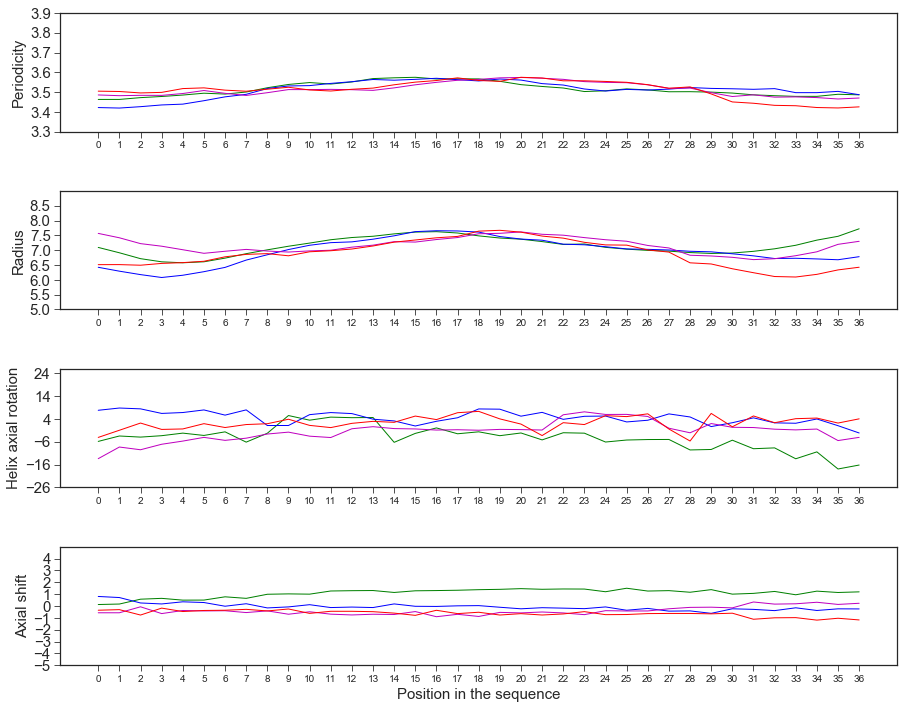

In [15]:
run_samcc_turbo('1qx8.pdb1', bin_paths=bin_paths)

Saving pymol session with layers...
1qx8 saved.


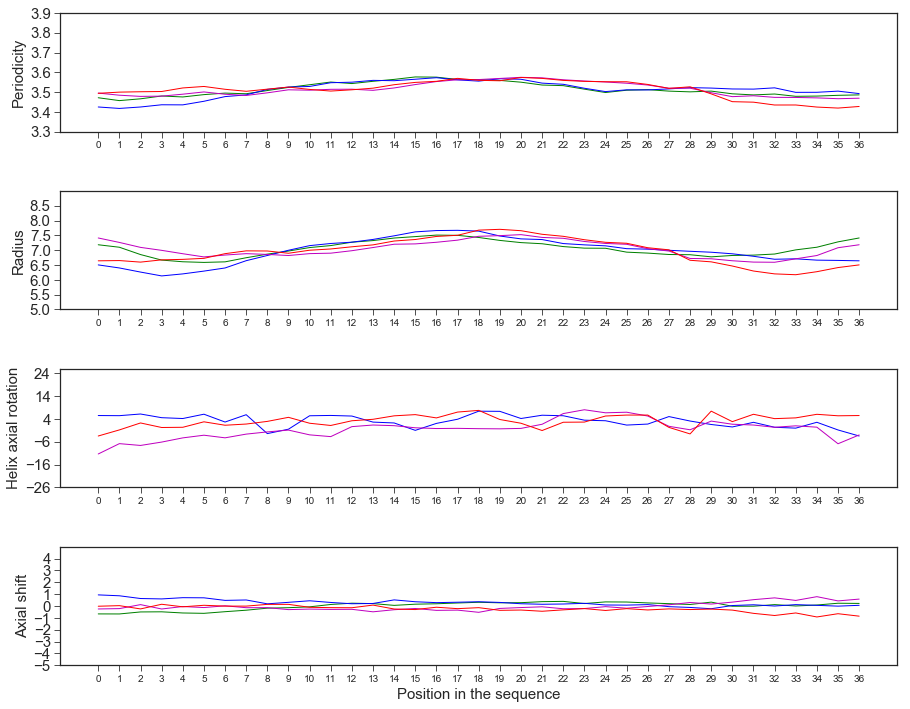

In [16]:
defdata = [[range(8, 47), range(8, 47), range(8,47)[::-1], range(8,47)[::-1]],
           ['A', 'B', 'C', 'D'],
           [False, False, True, True],
           ['e', 'd', 'g', 'g']]

run_samcc_turbo('1qx8.pdb1', mode='defdata', defdata=defdata)